# Final Project Repository

In [1]:
library(tidyverse)
library(repr)
library(infer)
library(cowplot)
library(broom)
library(modelr)
library(pROC)
library(rsample)
library(caret)
install.packages("glmnet")
library(glmnet)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp



Attaching package: ‘modelr’


The following object is masked from ‘package:broom’:

    bootstrap


Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    l

### Introduction



### Methods and Results

#### a) Exploratory Data Analysis

In [2]:
email <- read_csv(url("https://www.openintro.org/data/csv/email.csv"))
email <- email |>
    select(-time, -viagra) |>
    mutate(across(c(spam, to_multiple, from, sent_email, winner, format, re_subj, exclaim_subj, urgent_subj, number), as.factor))

Rows: 3921 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (2): winner, number
dbl  (18): spam, to_multiple, from, cc, sent_email, image, attach, dollar, i...
dttm  (1): time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


#### b) Methods: Plan

In [3]:
set.seed(3)

email_split <- initial_split(email, prop = 0.7, strata = spam)

email_training <- training(email_split)

email_testing <- testing(email_split)

matrix_X_train <- 
    model.matrix(object = spam ~ .,
                 data = email_training)[,-1]

matrix_Y_train <- 
    as.matrix(email_training$spam, ncol = 1)

20 x 1 sparse Matrix of class "dgCMatrix"
                        s0
(Intercept)    3.360152049
to_multiple1  -2.160884257
from1         -3.662802449
cc             0.026470888
sent_email1   -4.582798080
image         -1.169070794
attach         0.464846082
dollar        -0.065503955
winneryes      1.905970532
inherit        0.291403655
password      -0.609556804
num_char       .          
line_breaks   -0.002686705
format1       -0.622305227
re_subj1      -1.789314087
exclaim_subj1  .          
urgent_subj1   3.556141846
exclaim_mess   0.008256679
numbernone     0.161046645
numbersmall   -0.888828627

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”



Call:
glm(formula = spam ~ . - num_char - exclaim_subj, family = "binomial", 
    data = email_training)

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)   2.083e+01  1.773e+04   0.001 0.999063    
to_multiple1 -2.347e+00  3.524e-01  -6.662 2.70e-11 ***
from1        -2.107e+01  1.773e+04  -0.001 0.999052    
cc            2.902e-02  2.641e-02   1.099 0.271860    
sent_email1  -1.988e+01  4.851e+02  -0.041 0.967310    
image        -1.661e+00  6.102e-01  -2.721 0.006504 ** 
attach        6.578e-01  1.584e-01   4.153 3.29e-05 ***
dollar       -7.671e-02  3.175e-02  -2.416 0.015686 *  
winneryes     2.018e+00  4.372e-01   4.617 3.90e-06 ***
inherit       3.162e-01  1.560e-01   2.028 0.042596 *  
password     -8.461e-01  3.887e-01  -2.176 0.029519 *  
line_breaks  -2.984e-03  5.916e-04  -5.045 4.55e-07 ***
format1      -5.958e-01  1.721e-01  -3.462 0.000537 ***
re_subj1     -1.933e+00  4.804e-01  -4.024 5.72e-05 ***
urgent_subj1  3.865e+00  1.320e+00   2.

Setting levels: control = 0, case = 1

Setting direction: controls < cases



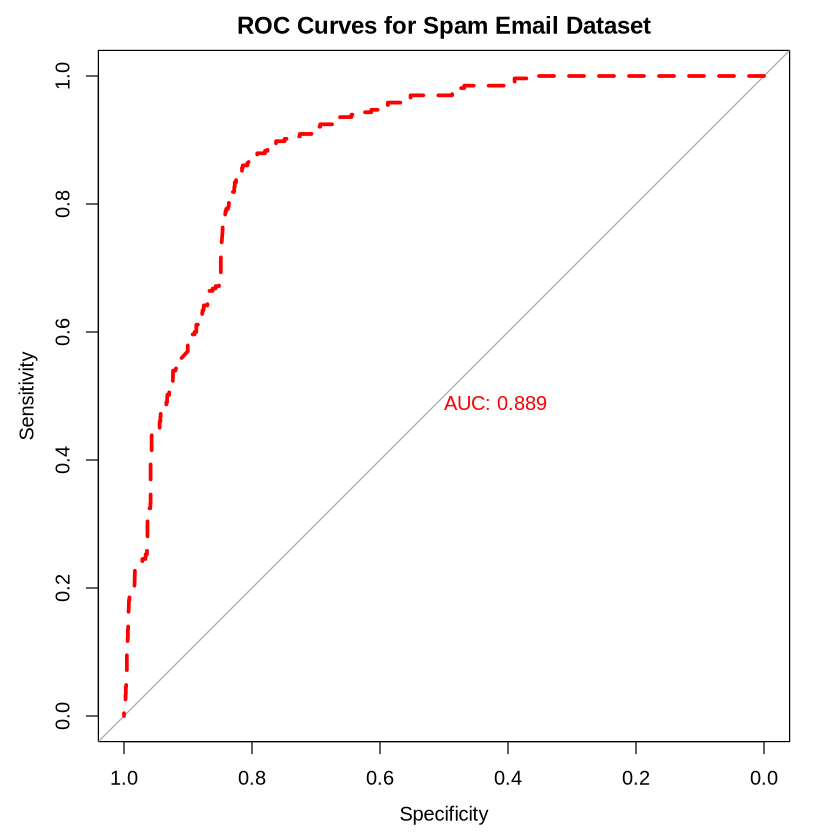

In [10]:
set.seed(4)
email_cv_lambda_LASSO <- cv.glmnet(
    x = matrix_X_train, y = matrix_Y_train,
    alpha = 1,
    family = "binomial",
    type.measure = "auc",
    nfolds = 5
    )

lambda_min_AUC_LASSO <- round(email_cv_lambda_LASSO$lambda.min, 4)

email_LASSO_min_AUC <- 
    glmnet(
        x = matrix_X_train, 
        y = matrix_Y_train,
        alpha = 1,
        family = "binomial",
        lambda = lambda_min_AUC_LASSO)

coef(email_LASSO_min_AUC)

chosen_model = glm(spam~.-num_char-exclaim_subj, data = email_training, family = "binomial")
summary(chosen_model)


ROC = roc(
    response = email_training$spam,
    predictor = predict(chosen_model, type = "response")
)

plot(ROC,
    print.auc = TRUE, col = "red", lwd = 3, lty = 2,
     main = "ROC Curves for Spam Email Dataset"
)

In [11]:
 # code adapted from worksheet 10
email_pred_class <- 
  round(predict(chosen_model, email_testing, type = "response"), 0)

email_confusion_matrix <- 
    confusionMatrix(
    data = as.factor(email_pred_class),
    reference = as.factor(email_testing$spam),
    positive = "1"
)

# show confusion matrix
email_confusion_matrix$table

# store confusion matrix metrics in a table
conf_mat_stats <- tibble(Sensitivity = c(email_confusion_matrix$byClass["Sensitivity"]),
                         Specificity = c(email_confusion_matrix$byClass["Specificity"]),
                         Precision = c(email_confusion_matrix$byClass["Precision"]),
                         Accuracy = c(email_confusion_matrix$overall["Accuracy"]),
                         Kappa = c(email_confusion_matrix$overall["Kappa"]))
conf_mat_stats   



          Reference
Prediction    0    1
         0 1072   87
         1    3   15

Sensitivity,Specificity,Precision,Accuracy,Kappa
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.1470588,0.9972093,0.8333333,0.9235344,0.2299808


### Discussion

### References